In [1]:
# Imports
from tvb.simulator.lab import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch, hilbert, coherence

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tvb/datatypes/surfaces.py:60: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


In [2]:
# Loading Default Dataset
conn = connectivity.Connectivity.from_file()
region_labels = conn.region_labels

2024-08-18 21:58:40,694 - WARNING - tvb.basic.readers - File 'hemispheres' not found in ZIP.


In [3]:
# Define electrode regions and nearby stimulation regions
electrode_region_indices = [14, 52]  # These could correspond to actual electrode locations in the brain
nearby_stim_indices = [11, 49]  # Assume these are regions near the electrode locations

In [4]:
# Display the selected regions
print("Electrode regions:", region_labels[electrode_region_indices])
print("Nearby stimulation regions:", region_labels[nearby_stim_indices])

Electrode regions: ['rPCIP' 'lPCIP']
Nearby stimulation regions: ['rIP' 'lIP']


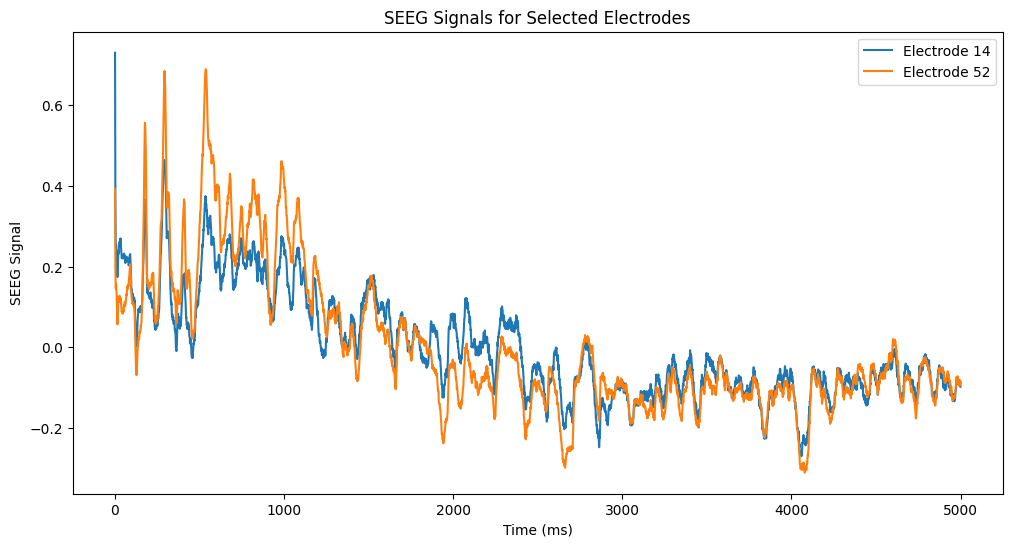

In [19]:
electrode_indices = [14, 52]  # Modify based on your electrodes of interest

# Create a figure to plot the data
plt.figure(figsize=(12, 6))

# Loop through each electrode and plot its signal
for idx in electrode_indices:
    plt.plot(ttavg, seeg[:, 0, idx, 0], label=f'Electrode {idx}')

# Add labels, title, and legend
plt.title('SEEG Signals for Selected Electrodes')
plt.xlabel('Time (ms)')
plt.ylabel('SEEG Signal')
plt.legend()
plt.show()


In [5]:
# Configure the spatial pattern of the stimulus
weighting = np.zeros((76,))
weighting[electrode_region_indices + nearby_stim_indices] = 0.1  # Stimulate both electrode and nearby regions

In [6]:
# Initialize Epileptor Model
epileptors = models.Epileptor(Ks=np.array([-2]), r=np.array([0.0002]), tau=np.array([10]), tt=np.array([0.07]))
epileptors.x0 = -2.4 * np.ones(len(conn.region_labels))
epileptors.x0[0] = -1.6  # Set one region to have a higher likelihood of seizure activity

# Set up the coupling and integrator
coupl = coupling.Difference(a=np.array([1.0]))
hiss = noise.Additive(nsig=np.array([0.001, 0.001, 0.0, 0.0001, 0.0001, 0.0]))
heunint = integrators.HeunStochastic(dt=0.05, noise=hiss)

In [7]:
# Monitoring
mon_tavg = monitors.TemporalAverage(period=1.0)
variables_of_interest = np.array([0, 1])

# SEEG monitoring assuming electrodes at indices 0 and 1
mon_SEEG = monitors.iEEG.from_file(
    sensors_fname='seeg_588.txt',
    projection_fname='/Users/mac/Downloads/tvb-root/tvb_data/projectionMatrix/projection_seeg_588_surface_16k.npy',
    period=1.0,
    variables_of_interest=variables_of_interest
)

In [8]:
# Simulation Function with varying onsets
def run_simulation(stimulus_onset, stimulus_interval):
    eqn_t = equations.PulseTrain()
    eqn_t.parameters['onset'] = stimulus_onset
    eqn_t.parameters['T'] = stimulus_interval
    eqn_t.parameters['tau'] = 50.0

    stimulus = patterns.StimuliRegion(temporal=eqn_t, connectivity=conn, weight=weighting)
    stimulus.configure_space()
    stimulus.configure_time(np.arange(0., 3e3, 2**-4))

    sim = simulator.Simulator(
        model=epileptors,
        connectivity=conn,
        coupling=coupl,
        integrator=heunint,
        monitors=[mon_tavg, mon_SEEG],
        stimulus=stimulus,
        simulation_length=5000  # 5 seconds for each simulation
    ).configure()

    (ttavg, tavg), (tseeg, seeg) = sim.run()

    # Normalize the time series for better visualization
    seeg /= (np.max(seeg, 0) - np.min(seeg, 0))
    seeg -= np.mean(seeg, 0)

    return ttavg, tavg, tseeg, seeg

In [9]:
# Set up different onset times and intervals for the stimulus
stimulus_onsets = [500, 1000]  # in ms
stimulus_intervals = [50, 100]  # in ms

# Run simulations for each combination of stimulus onset and interval
results = []
for onset in stimulus_onsets:
    for interval in stimulus_intervals:
        ttavg, tavg, tseeg, seeg = run_simulation(stimulus_onset=onset, stimulus_interval=interval)
        results.append((onset, interval, ttavg, tavg, tseeg, seeg))

2024-08-18 22:00:52,033 - INFO - tvb.simulator.monitors - Projection configured gain shape (588, 76)
2024-08-18 22:01:05,951 - ERROR - tvb.simulator.simulator - Bad Simulator.integrator.noise.nsig shape: (6, 1, 1)
2024-08-18 22:01:20,273 - ERROR - tvb.simulator.simulator - Bad Simulator.integrator.noise.nsig shape: (6, 1, 1)
2024-08-18 22:01:33,402 - ERROR - tvb.simulator.simulator - Bad Simulator.integrator.noise.nsig shape: (6, 1, 1)


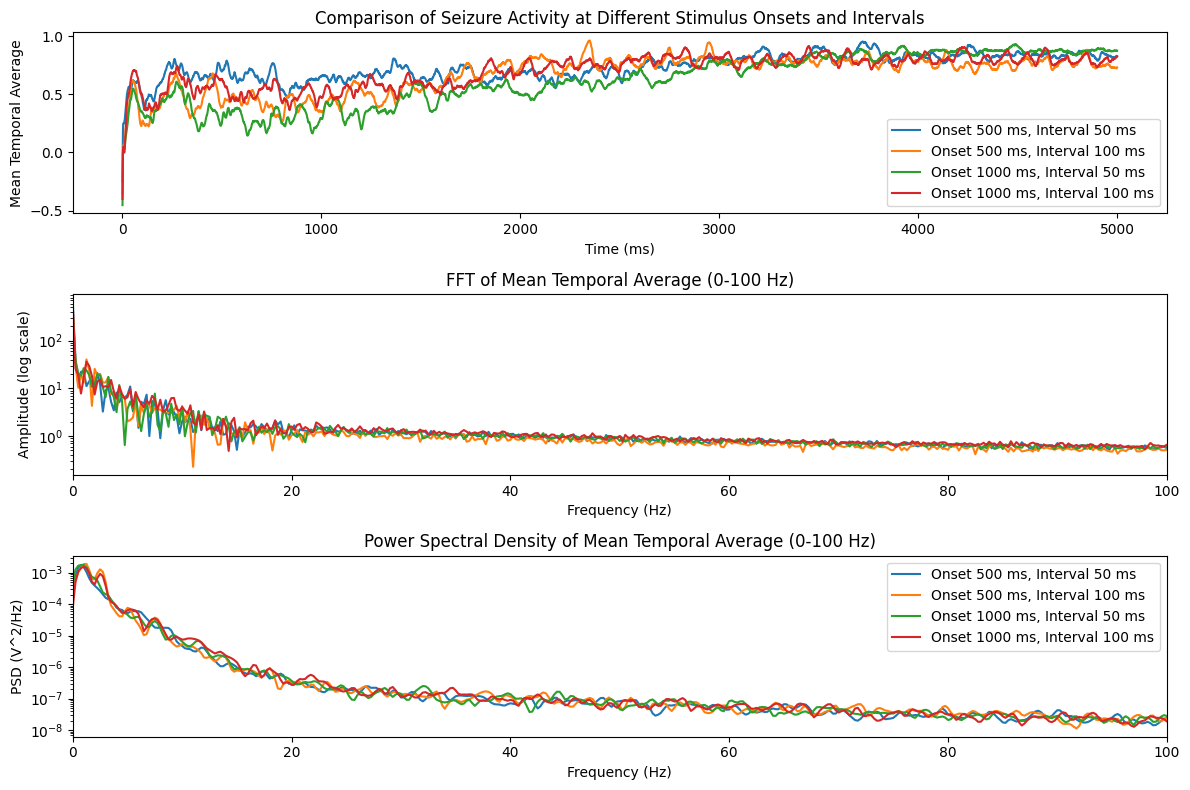

In [10]:
# Comparison, FFT, and PSD
plt.figure(figsize=(12, 8))

for onset, interval, ttavg, tavg, tseeg, seeg in results:
    mean_temporal_avg = tavg[:, 0, :, 0].mean(axis=1)
    
    # Perform FFT with higher resolution
    nfft = 2**10  # Using 1024 points for FFT for finer frequency resolution
    fft = np.fft.fft(mean_temporal_avg, n=nfft)
    freq = np.fft.fftfreq(nfft, d=1/256)
    
    # Filter to keep only frequencies between 0 and 100 Hz
    pos_freqs = (freq >= 0) & (freq <= 100)
    pos_freqs_fft = fft[pos_freqs]
    pos_freqs_freq = freq[pos_freqs]
    
    # Calculate the PSD using Welch's method with higher resolution
    freqs, psd = welch(mean_temporal_avg, fs=256, nperseg=nfft//2, noverlap=nfft//4, nfft=nfft)
    
    # Filter the PSD frequencies to 0-100 Hz
    psd_range = freqs <= 100
    freqs = freqs[psd_range]
    psd = psd[psd_range]
    
    # Plot Mean Temporal Average
    plt.subplot(3, 1, 1)
    plt.plot(ttavg, mean_temporal_avg, label=f'Onset {onset} ms, Interval {interval} ms')
    plt.legend()
    plt.title('Comparison of Seizure Activity at Different Stimulus Onsets and Intervals')
    plt.ylabel("Mean Temporal Average")
    plt.xlabel('Time (ms)')
    
    # Plot FFT of Mean Temporal Average (0-100 Hz)
    plt.subplot(3, 1, 2)
    plt.plot(pos_freqs_freq, np.abs(pos_freqs_fft), label=f'Onset {onset} ms, Interval {interval} ms')
    plt.yscale('log')  # Use logarithmic scale for amplitude
    plt.xlim(0, 100)
    plt.title('FFT of Mean Temporal Average (0-100 Hz)')
    plt.ylabel('Amplitude (log scale)')
    plt.xlabel('Frequency (Hz)')
    
    # Plot PSD of Mean Temporal Average (0-100 Hz)
    plt.subplot(3, 1, 3)
    plt.semilogy(freqs, psd, label=f'Onset {onset} ms, Interval {interval} ms')
    plt.legend()
    plt.title('Power Spectral Density of Mean Temporal Average (0-100 Hz)')
    plt.xlim(0, 100)
    plt.ylabel('PSD (V^2/Hz)')
    plt.xlabel('Frequency (Hz)')

plt.tight_layout()
plt.show()


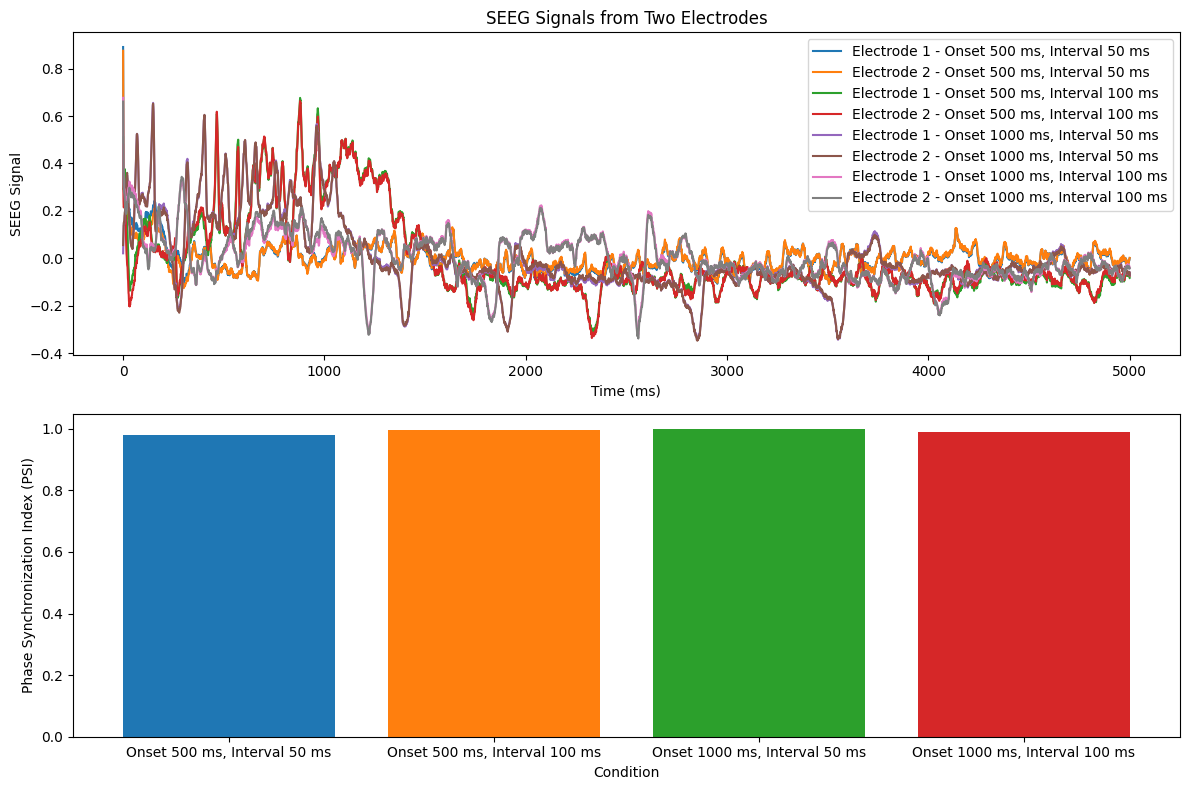

In [13]:
# Attempt one at evaluating phase synchronization
# Function to calculate phase synchronization
def calculate_phase_synchronization(signal1, signal2):
    # Calculate the analytic signal (Hilbert transform) for each signal
    analytic_signal1 = hilbert(signal1)
    analytic_signal2 = hilbert(signal2)
    
    # Extract the instantaneous phase
    phase1 = np.angle(analytic_signal1)
    phase2 = np.angle(analytic_signal2)
    
    # Calculate phase difference
    phase_diff = np.abs(phase1 - phase2)
    
    # Calculate phase synchronization index (PSI)
    psi = np.abs(np.mean(np.exp(1j * phase_diff)))
    
    return psi

plt.figure(figsize=(12, 8))
for onset, interval, ttavg, tavg, tseeg, seeg in results:
    electrode1_signal = seeg[:, 0, 0, 0]  # First electrode
    electrode2_signal = seeg[:, 0, 1, 0]  # Second electrode
    
    # Plot the signals
    plt.subplot(2, 1, 1)
    plt.plot(ttavg, electrode1_signal, label=f'Electrode 1 - Onset {onset} ms, Interval {interval} ms')
    plt.plot(ttavg, electrode2_signal, label=f'Electrode 2 - Onset {onset} ms, Interval {interval} ms')
    plt.legend()
    plt.title('SEEG Signals from Two Electrodes')
    plt.ylabel("SEEG Signal")
    plt.xlabel('Time (ms)')
    
    # Calculate and plot phase synchronization
    psi = calculate_phase_synchronization(electrode1_signal, electrode2_signal)
    plt.subplot(2, 1, 2)
    plt.bar(f'Onset {onset} ms, Interval {interval} ms', psi)
    plt.ylabel('Phase Synchronization Index (PSI)')
    plt.xlabel('Condition')

plt.tight_layout()
plt.show()

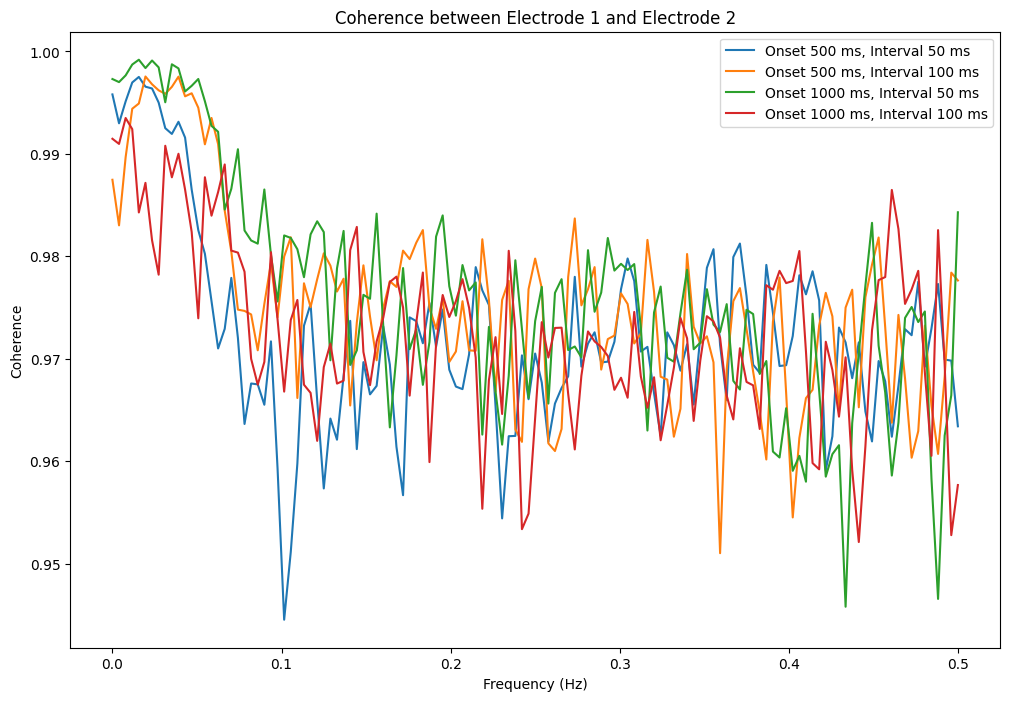

In [15]:
# Attempt two at evaluating phase synchronization
plt.figure(figsize=(12, 8))
for onset, interval, ttavg, tavg, tseeg, seeg in results:
    # Compute coherence between the two electrodes
    f, Cxy = coherence(seeg[:, 0, 0, 0], seeg[:, 0, 1, 0], fs=1/(ttavg[1] - ttavg[0]), nperseg=256)
    
    plt.plot(f, Cxy, label=f'Onset {onset} ms, Interval {interval} ms')

plt.title('Coherence between Electrode 1 and Electrode 2')
plt.ylabel('Coherence')
plt.xlabel('Frequency (Hz)')
plt.legend()
plt.show()

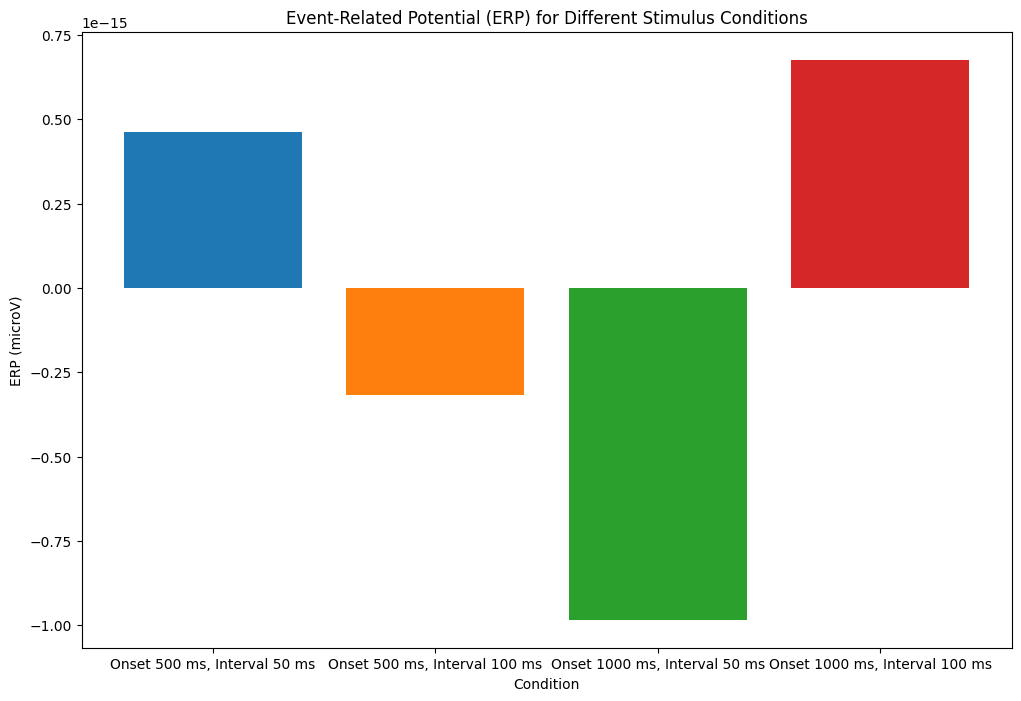

In [16]:
# Plot Event-Related Potential (ERP)
plt.figure(figsize=(12, 8))
for onset, interval, ttavg, tavg, tseeg, seeg in results:
    # Compute ERP for electrode 1 by averaging across all time points
    erp = np.mean(seeg[:, 0, 0, 0])
    plt.bar(f'Onset {onset} ms, Interval {interval} ms', erp)
    
plt.title('Event-Related Potential (ERP) for Different Stimulus Conditions')
plt.ylabel('ERP (microV)')
plt.xlabel('Condition')
plt.show()

ValueError: operands could not be broadcast together with shapes (5000,588) (76,) 

<Figure size 1500x1500 with 0 Axes>

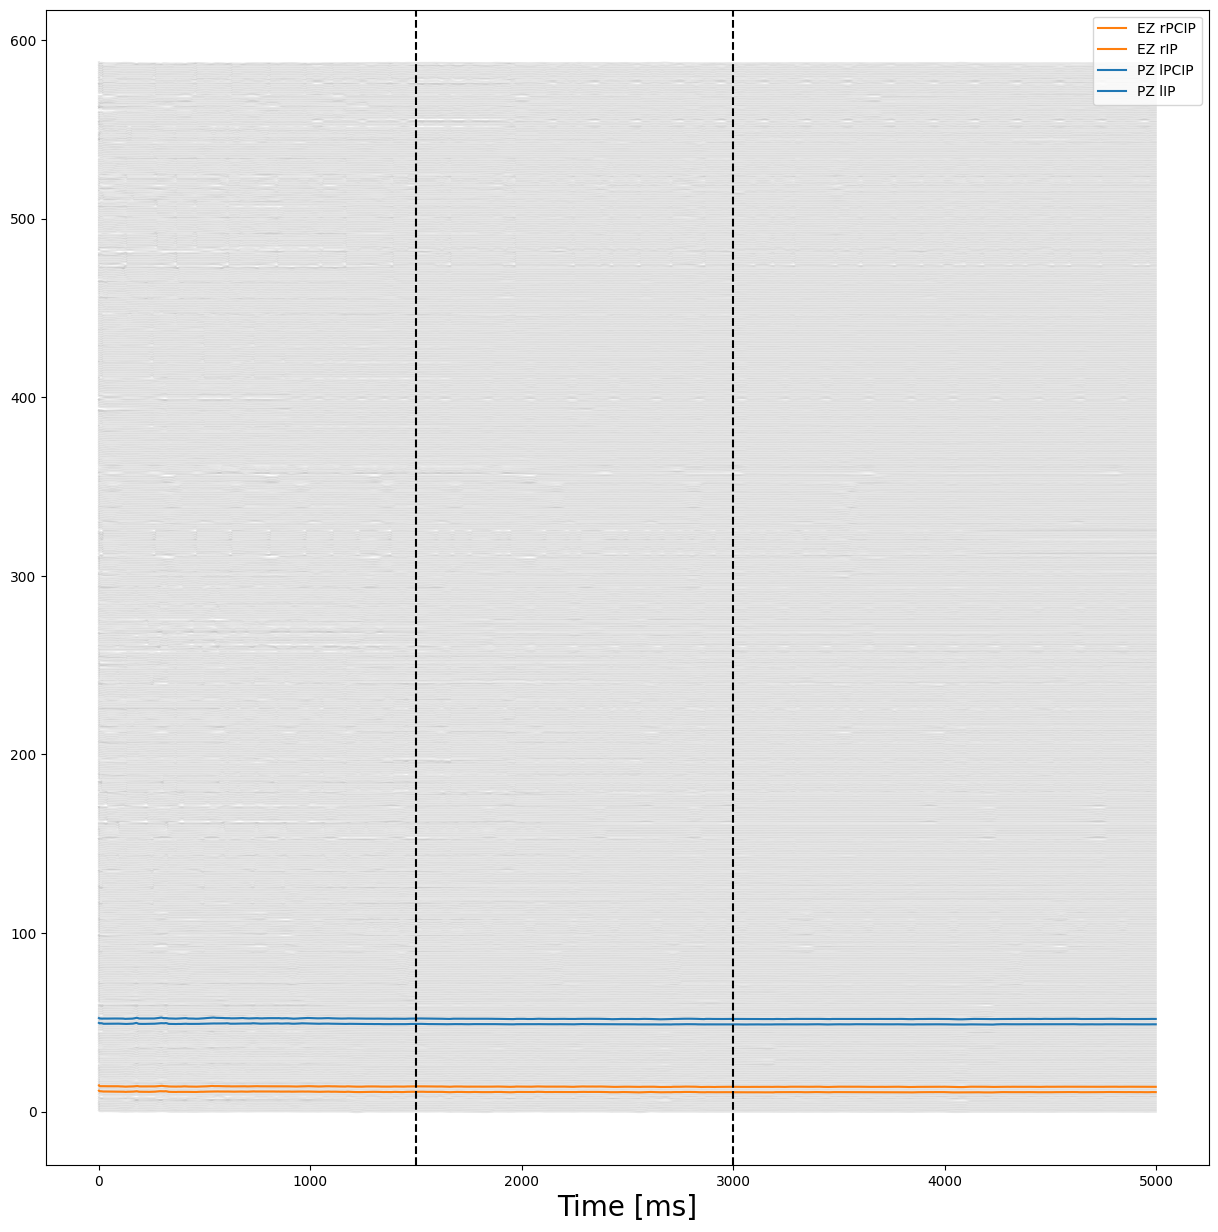

In [23]:

# Define the time range for the plot
time_range = np.arange(0, 5000)

# Plot time series for all regions
fig1 = plt.figure(figsize=(15, 15))

# Plot all regions
for i in range(seeg.shape[2]):  # Iterate over all regions
    if i < seeg.shape[2]:  # Ensure index is within bounds
        plt.plot(time_range, seeg[:5000, 0, i, 0] + i, 'k', alpha=0.1)

# Highlight Epileptogenic Zones (EZ) and Propagation Zones (PZ)
EZs = [electrode_region_indices[0], nearby_stim_indices[0]]
PZs = [electrode_region_indices[1], nearby_stim_indices[1]]
EN = EZs + PZs
idx = np.arange(len(EN))

# Plot highlighted regions
for ie, ez in enumerate(EZs):
    if ez < seeg.shape[2]:  # Ensure index is within bounds
        plt.plot(time_range, seeg[:5000, 0, ez, 0] + ez, 'C1', label=f'EZ {conn.region_labels[ez]}')
for ip, pz in enumerate(PZs):
    if pz < seeg.shape[2]:  # Ensure index is within bounds
        plt.plot(time_range, seeg[:5000, 0, pz, 0] + pz, 'C0', label=f'PZ {conn.region_labels[pz]}')

plt.axvline(x=1500, color='k', linestyle='--')  # Adjust vertical lines if needed
plt.axvline(x=3000, color='k', linestyle='--')  # Adjust vertical lines if needed

plt.xlabel('Time [ms]', fontsize=20)
plt.legend(loc='upper right')
plt.show()

In [24]:
# Plot time series.
fig1 = plt.figure(figsize=(15,15))
plt.plot(DATA[:, :] + np.r_[:nregions], 'k', alpha=0.1)
plt.yticks(np.arange(len(con.region_labels)), con.region_labels, fontsize=10)

EZs = [14, 52]
for ie, ez in enumerate(EZs):
    plt.plot(DATA[:, EZs[ie]] + EZs[ie], 'C1')
    
# plt.title('Resting-state with seizures', fontsize=20)
plt.xlabel('Time [ms]', fontsize=20)

plt.show()

NameError: name 'DATA' is not defined

<Figure size 1500x1500 with 0 Axes>